# Lightcones using SQL  against Millennium Databases @ JHU
Determine the min/max depth of a light cone segment for the MR.
Use these to define light cone segments.
Upload to MyDB

Find subhalos in light cone built from these segments.


In [4]:
import numpy as np
import pandas
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM

import SciServer.CasJobs as cj

### simulations documented at
http://gavo.mpa-garching.mpg.de/Millennium/Help/simulation

In [5]:
MR=FlatLambdaCDM(H0=73,Om0=0.25)
MR.MR_name='MR'
MR.box=500
MR.bits=8
MRII=FlatLambdaCDM(H0=73,Om0=0.25)
MRII.MR_name='MRII'
MRII.box=100
MRII.bits=8
MRscPlanck1=FlatLambdaCDM(H0=67.3,Om0=0.315)
MRscPlanck1.MR_name='MRscPlanck1'
MRscPlanck1.box=480.279
MRscPlanck1.bits=8

In [6]:
def load_snapshots(cos):
    '''
    TODO deal with negative redshifts for MRscPlanck1
    '''
    cos.snapshots=cj.executeQuery("select * from {0} order by z".format(cos.MR_name),"snapshots")
    z=cos.snapshots['z']
    intervals=[(s,(a + b) / 2,(b+c)/2) for a, b,c,s in zip(z, z[1:], z[2:],cos.snapshots['snapnum'][1:])]
    intervals.insert(0,(63,0,intervals[0][1]))
    intervals=list(zip(*intervals))
    df_intervals=pandas.DataFrame()
    h=cos.H0.value/100
    df_intervals['snapnum']=intervals[0]
    df_intervals['lo']=cos.comoving_distance(intervals[1])*h
    df_intervals['hi']=cos.comoving_distance(intervals[2])*h
    cos.segments=df_intervals


In [7]:
load_snapshots(MR)
#cj.uploadPandasDataFrameToTable(MR.segments,tableName="MR_segments")

In [8]:
load_snapshots(MRscPlanck1)
#cj.uploadPandasDataFrameToTable(MRscPlanck1.segments,tableName="MRscPlanck1_segments")

In [9]:
load_snapshots(MRII)
#cj.uploadPandasDataFrameToTable(MRII.segments,tableName="MRII_segments")

# apply to MPAHalotrees

In [238]:
# Use this IF you want to have a coordinate system aligned with the cone. 
class CoordSystem():
    """
    3D cartesian coordinate system.
    defined by a single axis that serves as y-axis.
    x-axis is found by finding vector in X/Y-plane, orthogonal to y-axis
    """
    def __init__(self, yp):
        self.coordAxes(yp)
        
    def coordAxes(self,yp):
        """
        Only fails if yp is parallel to z-axis
        """
        y_axis=np.array(yp)
        y_axis=y_axis/np.linalg.norm(y_axis)
        zp=np.array([0,0,1])
        x_axis=np.cross(y_axis,zp)
        z_axis=np.cross(x_axis,y_axis)
        self.m=np.array([x_axis,y_axis,z_axis])

    def project(self,v):
        return self.m.dot(v)

In [29]:
def localCoordsys(df, D):
    """
    Expects a df with x,y,z
    """
    coords = CoordSystem(D)
    xyz=coords.m.dot(df[['x','y','z']].values.T)
    df['xp']=xyz[0]
    df['yp']=xyz[1]
    df['zp']=xyz[2]

def addPolar(df, coordsys=None):
    """
    Expects a df with x,y,z
    """
    df['r']=np.sqrt(df['x']**2+df['y']**2+df['z']**2)
    xyz=df[['x','y','z']].values
    xy = xyz[:,0]**2 + xyz[:,1]**2
    df['dec'] = np.degrees(np.arctan2(xyz[:,2], np.sqrt(xy))) # for elevation angle defined from XY-plane up
    df['ra'] = np.degrees(np.arctan2(xyz[:,1], xyz[:,0]))%360
        

In [10]:

def lightcone(sim, O, D, angle, lo_z, hi_z):
    """
    sim: simulation/cosmology object. astropy.cosmology.FlatLambdaCDM with MR sim properties
    O: origin [x,y,z]
    D: direction [dx,dy,dz]
    angle: opening angle in degrees
    lo: lowest redshift
    hi: highest redshift
    """
    h=sim.H0.value/100
    lo_cm=sim.comoving_distance(lo_z).value*h
    hi_cm=sim.comoving_distance(hi_z).value*h
    
    sql="""
    declare @box dbo.Box=dbo.Box::New(0,0,0,{box},{box},{box})
    declare @lo real={lo}, @hi real={hi}, @angle real=RADIANS(cast({angle} as float))
    declare @bits tinyint = {bits}
      ;
    with lightcone as 
    (
      select snapnum
      ,      dbo.Shape::New(dbo.ConeSegment::New({O},{D}, @angle, dbo.math_max(@lo, lo), dbo.math_min(@hi,hi)).ToString()) as shape 
      from MyDB.{sim}_segments
        where lo <= @hi and hi >= @lo
    ),
    cover as (
    select snapnum,shape,c.*
    from lightcone cross apply dbo.fCover('H',@bits,@box,1,shape) c
      )
    select h.haloid,h.np,h.redshift, h.snapnum
      ,    h.x+sh.shiftx as x
      ,    h.y+sh.shifty as y
      ,    h.z+sh.shiftz as z
    from cover sh
      inner loop join MPAHalotrees.{sim} h
      on h.snapnum=sh.snapnum
      and h.phkey between sh.keymin and sh.keymax
      and sh.shape.ContainsPoint(h.x+sh.shiftx,h.y+sh.shifty,h.z+sh.shiftz)=1
    """.format(sim=sim.MR_name,box=sim.box,O=",".join(map(str, O)),D=",".join(map(str, D)), angle=angle,lo=lo_cm, hi=hi_cm, bits=sim.bits)
    
    df=cj.executeQuery(sql,"SimulationDB")    
    addPolar(df)
    return df


In [11]:

def cone(sim, O, D, angle, hi_cm, snapnum):
    """
    Returns halos in a cone through a snapshot. 
    I.e. NOT a lightcone!
    parameters:
    sim: simulation/cosmology object. astropy.cosmology.FlatLambdaCDM with MR sim properties
    O: origin [x,y,z]
    D: direction [dx,dy,dz]
    angle: opening angle in degrees
    lo: lowest redshift
    hi: highest redshift
    snapnum: the snapshot through which the cone should be made
    """
    
    sql="""
    declare @box dbo.Box=dbo.Box::New(0,0,0,{box},{box},{box})
    declare @hi real={hi}, @angle real=RADIANS(cast({angle} as float))
    declare @bits tinyint = {bits}
    declare @snapnum tinyint = {snapnum}
      ;
    with cone as 
    (
      select @snapnum as snapnum
      ,      dbo.Shape::New(dbo.Cone::New({O},{D}, @angle,@hi).ToString()) as shape 
    ),
    cover as (
    select snapnum,shape,c.*
    from cone cross apply dbo.fCover('H',@bits,@box,1,shape) c
      )
    select h.haloid,h.np,h.redshift, h.snapnum
      ,    h.x+sh.shiftx as x
      ,    h.y+sh.shifty as y
      ,    h.z+sh.shiftz as z
    from cover sh
      inner loop join MPAHalotrees.{sim} h with(index=ix_mr_snapnum_pos)
      on h.snapnum=sh.snapnum
      and h.phkey between sh.keymin and sh.keymax
      and sh.shape.ContainsPoint(h.x+sh.shiftx,h.y+sh.shifty,h.z+sh.shiftz)=1
    """.format(sim=sim.MR_name,box=sim.box,O=",".join(map(str, O)),D=",".join(map(str, D)), 
               angle=angle, hi=hi_cm, bits=sim.bits,snapnum=snapnum)
    
    df=cj.executeQuery(sql,"SimulationDB")    
    addPolar(df)
    return df


In [12]:
hi_z=.2
sim=MR
h=sim.H0.value/100
hi_cm=sim.comoving_distance(hi_z).value*h
print('hi_cm=',hi_cm)
snapnum=60
O=[0,0,0]
D=[1,1,1]
angle=2


hi_cm= 575.991900136839


In [13]:
df_cone=cone(sim=sim,O=[0,0,0],D=[1,1,1],angle=4,hi_cm=hi_cm,snapnum=snapnum)
len(df_cone)

148645

In [14]:
df=lightcone(sim=MR,O=[0,0,0],D=[1,1,1],angle=4,lo_z=0,hi_z=hi_z)
len(df)

148446

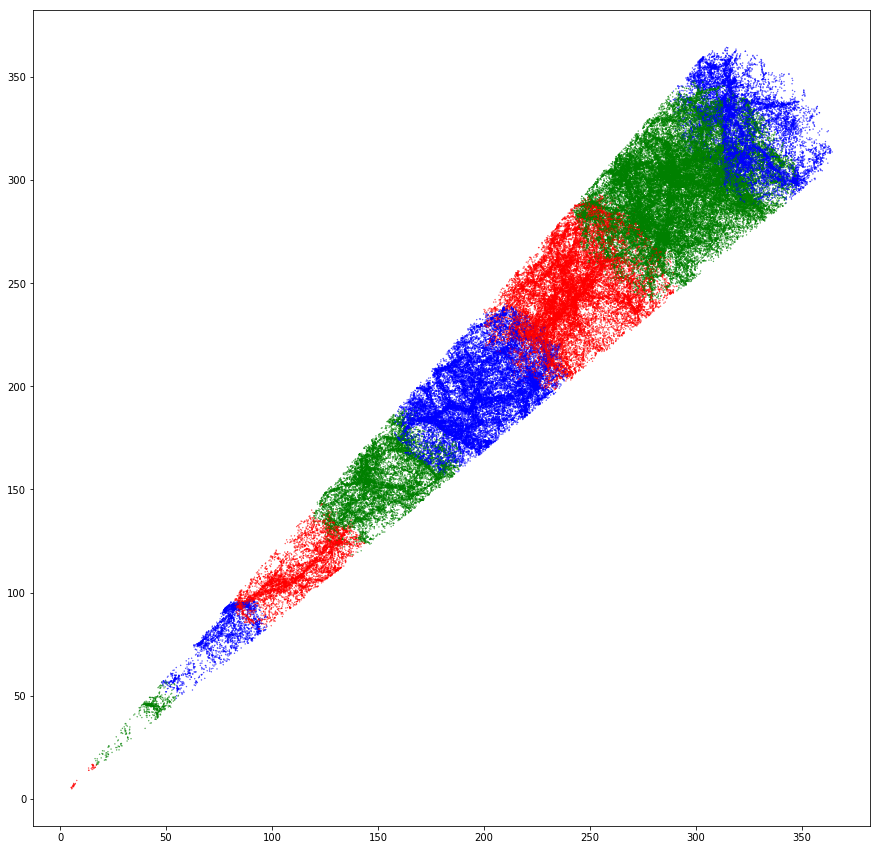

In [15]:
f=plt.figure(figsize=(15,15))
colors = ['red', 'blue','green']
plt.scatter(df['x'],df['y'],s=.1,c=(df['snapnum']%3).apply(lambda x: colors[x]));

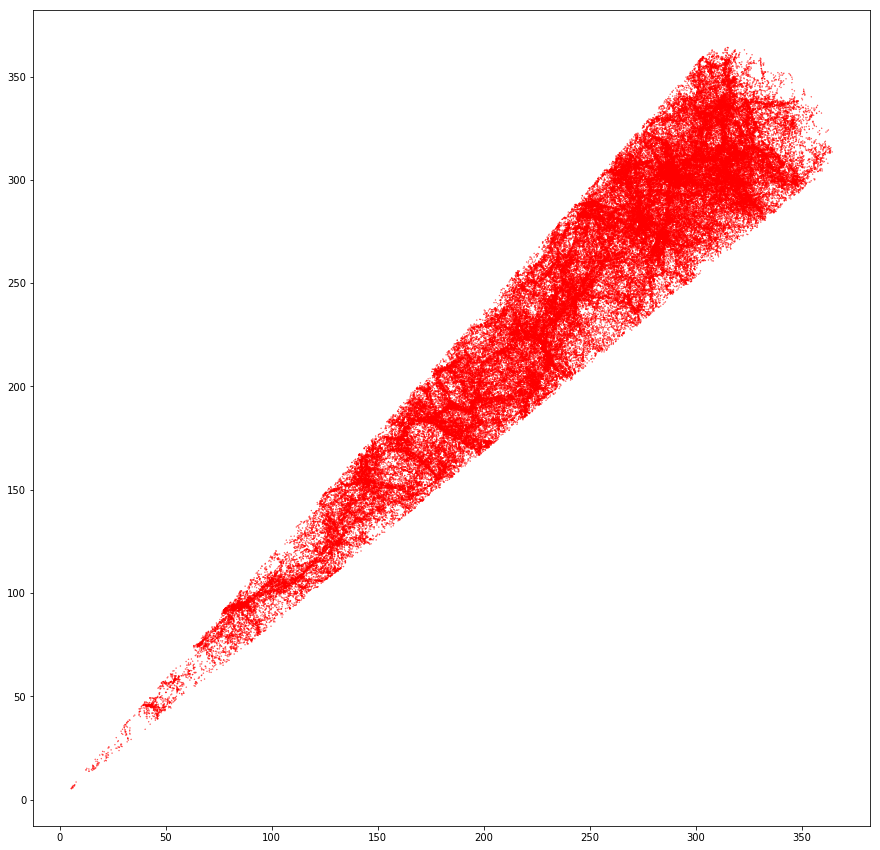

In [16]:
f=plt.figure(figsize=(15,15))
colors = ['red', 'blue','green']
plt.scatter(df_cone['x'],df_cone['y'],s=.1,c=(df_cone['snapnum']%3).apply(lambda x: colors[x]));

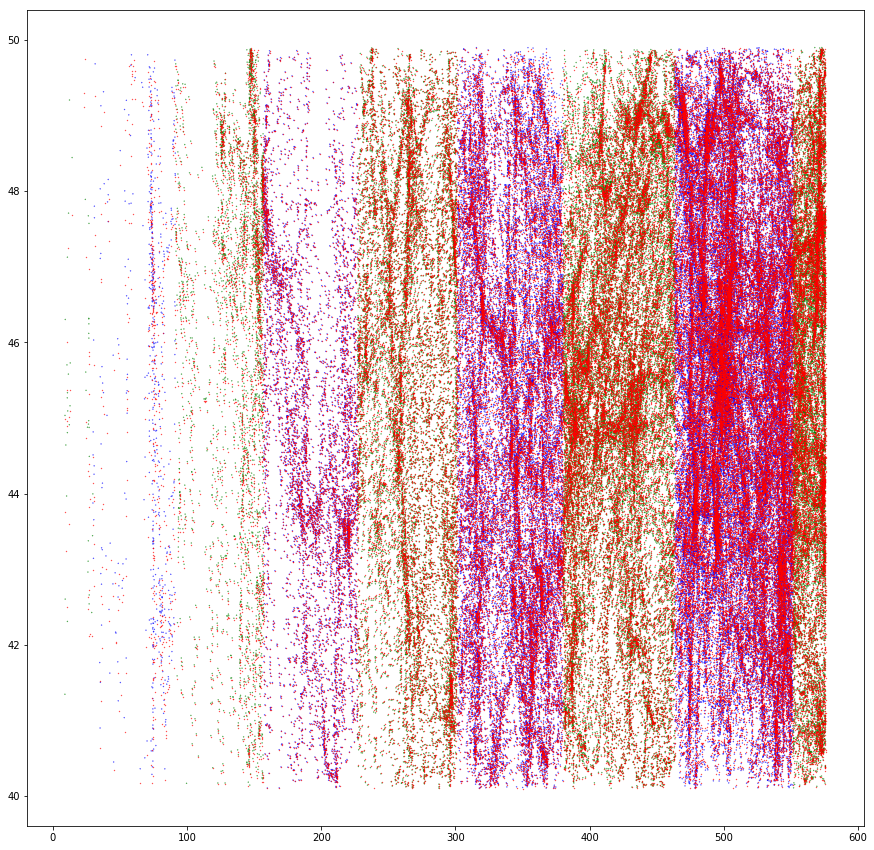

In [25]:
f=plt.figure(figsize=(15,15))
colors = ['blue','green']
c=[ colors[x%2] for x in df['snapnum'] ]
plt.scatter(df['r'],df['ra'],s=.1,c=c);
plt.scatter(df_cone['r'],df_cone['ra'],s=.1,color='red');
# plt.xlim(50,150)
# plt.ylim(50,150)


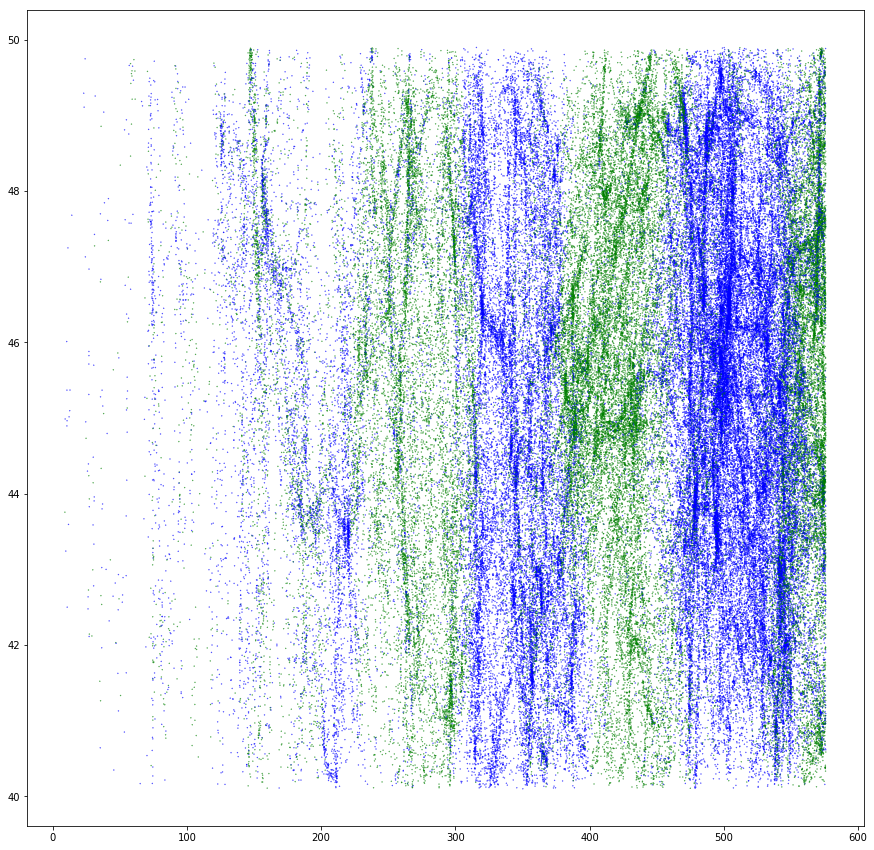

In [26]:
f=plt.figure(figsize=(15,15))
colors = ['blue','green']
c=[ colors[x%2] for x in df['snapnum'] ]
plt.scatter(df_cone['r'],df_cone['ra'],s=.1,c=c);

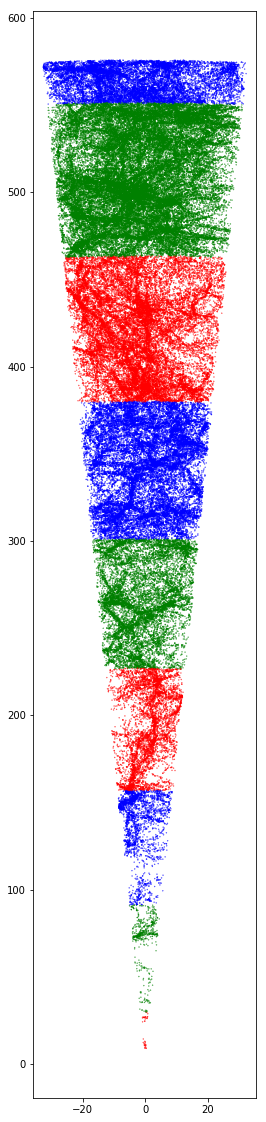

In [309]:
f=plt.figure(figsize=(4,20))

colors = ['red', 'blue','green']
plt.scatter(df['xp'],df['yp'],s=.1,c=(df['snapnum']%len(colors)).apply(lambda x: colors[x]));

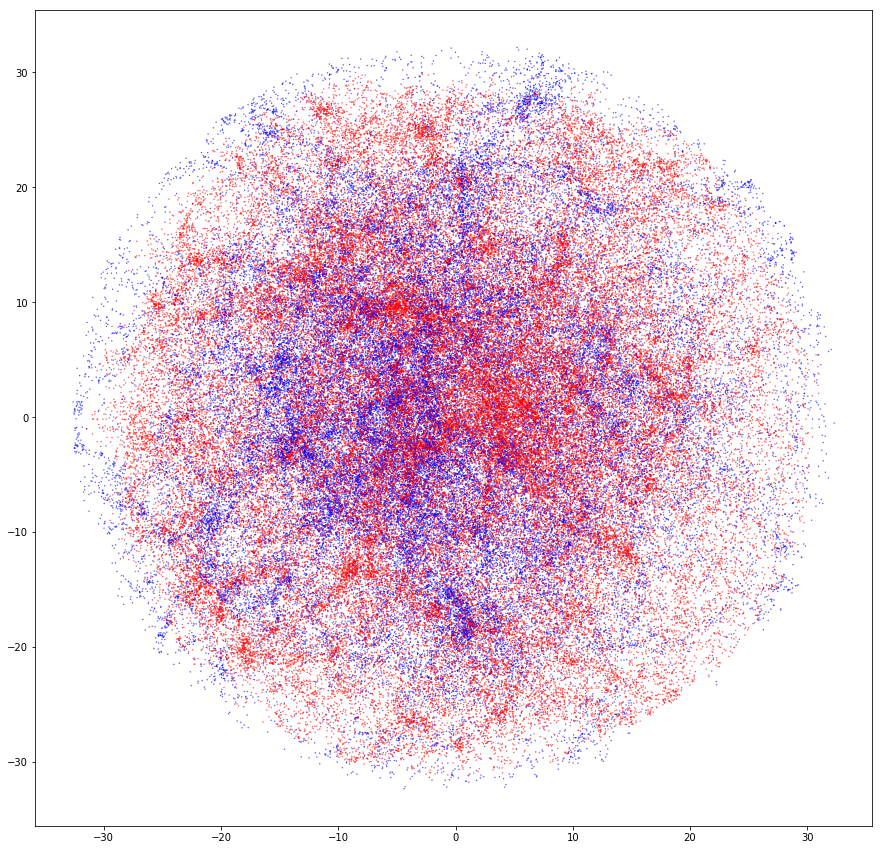

In [252]:
f=plt.figure(figsize=(15,15))

colors = ['red', 'blue']
plt.scatter(df['xp'],df['zp'],s=.1,c=(df['snapnum']%2).apply(lambda x: colors[x]));

In [304]:
def XYZ2RADec(xyz):
    """
    
    """
    xy = xyz[:,0]**2 + xyz[:,1]**2
    dec = np.degrees(np.arctan2(xyz[:,2], np.sqrt(xy))) # for elevation angle defined from XY-plane up
    ra = np.degrees(np.arctan2(xyz[:,1], xyz[:,0]))
    return ra,dec

In [305]:
ra,dec=XYZ2Spherical_np(df[['x','y','z']].values)

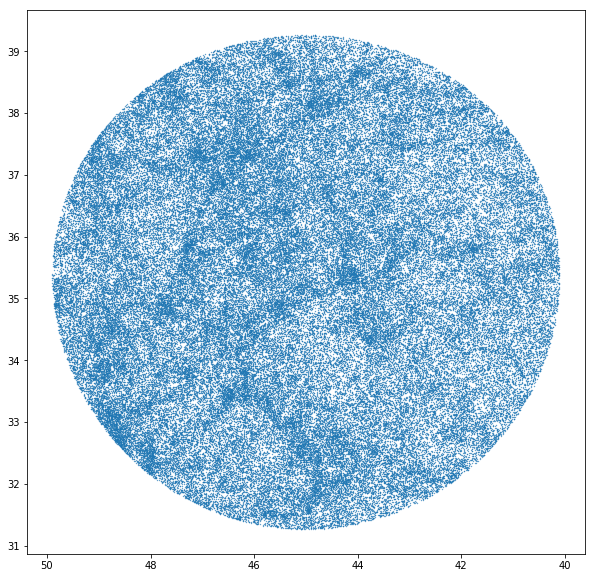

In [307]:
f=plt.figure(figsize=(10,10))
plt.scatter(ra,dec,s=.1);
plt.gca().invert_xaxis()